## (1) Data management
- `path`: path to raw csv data files
- `N_sample`: number of measurements

In [1]:
import csv
path = 'cisnienie/'
N_sample = 82

### (1.1) Fixing files

In [2]:
import os

#--- find all datafiles
datafiles = [os.path.join(path,file) for file in os.listdir(path)]

#--- fix files
for file in datafiles:
    newfile = file.replace('Specimen','SpecimenClean')
    # change encoding, crop header & save
    !uconv --from-code ISO_8859-1 --to-code UTF8 $file | tail -n +5 >> $newfile 
    os.remove(file)

### (1.2) Loading data 

In [3]:
force_all = []
strch_all = []

for sample in range(1, N_sample+1):
    file = path + f'SpecimenClean_RawData_{str(sample)}.csv'
    
    #--- single file data
    force = []
    strch = []

    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')    
        for row in reader:
            force.append(float(''.join([c for c in row[2] if c in '1234567890,']).replace(',','.')))
            strch.append(float(row[1].replace(',','.')))
    
    force_all.append(force)
    strch_all.append(strch)

NameError: name 'N_sample' is not defined

#### (1.2.1) Saving correct files (optional)

In [4]:
for sample in range(1, N_sample+1):
    
    file = path + f'SpecimenClean_RawData_{str(sample)}.csv'
    newfile = path + f'Specimen_RawData_correct_{str(sample).zfill(2)}.csv'

    time = []
    force = []
    strch = []

    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')    
        for row in reader:
            time.append(row[0])
            strch.append(row[1])
            force.append(''.join([c for c in row[2] if c in '1234567890,']))

    with open(newfile, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        for tim, strc, forc in zip(time, strch, force):
            writer.writerow([tim]+[strc]+[forc])

### (1.3) Plotting raw data...

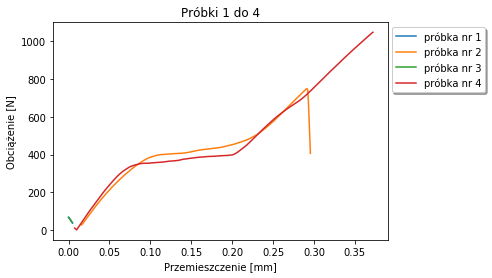

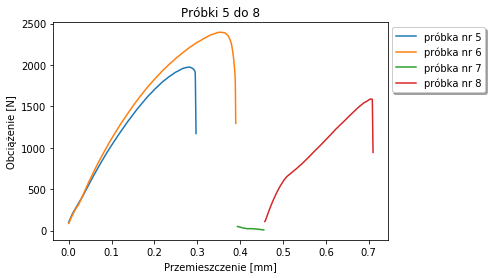

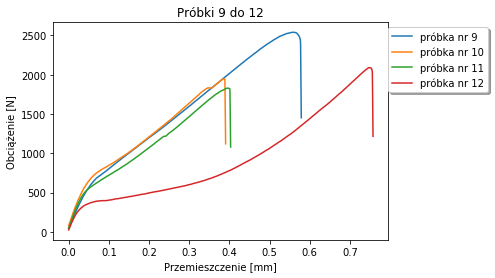

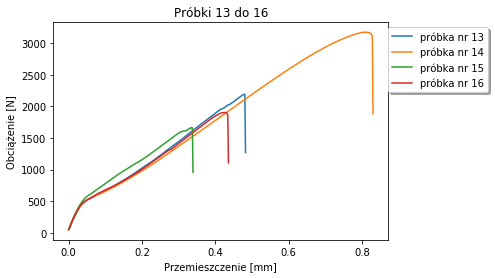

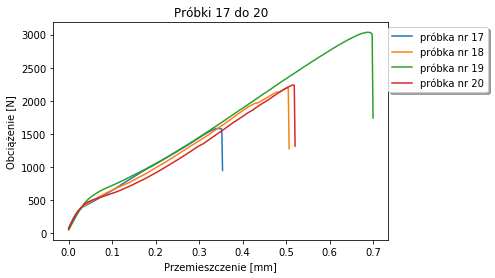

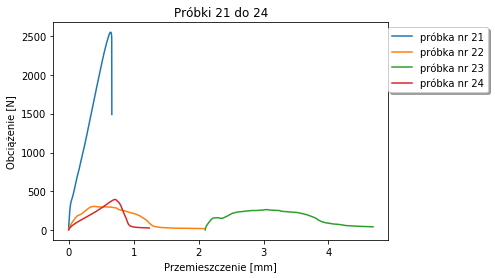

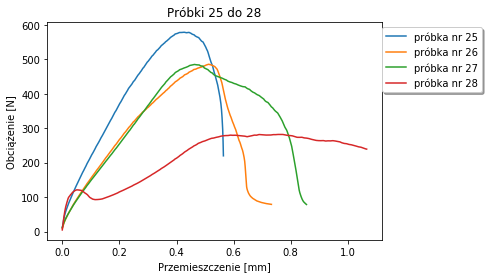

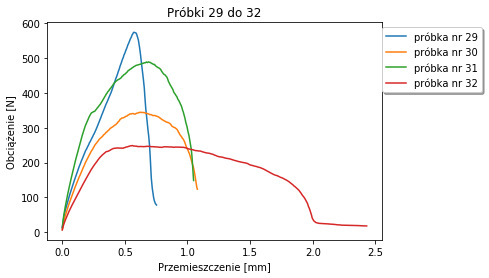

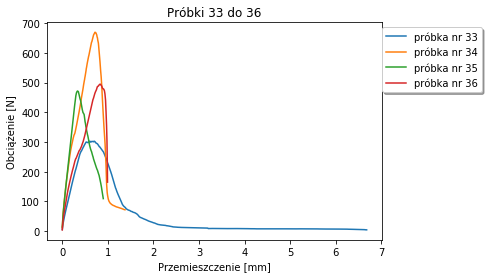

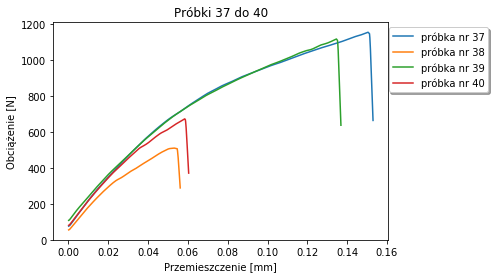

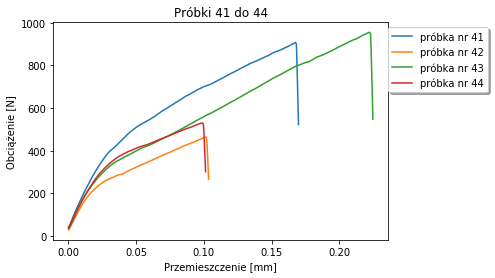

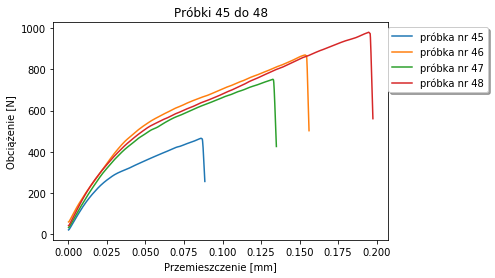

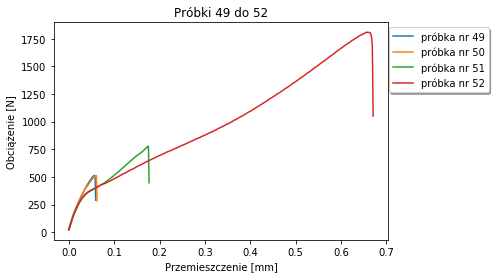

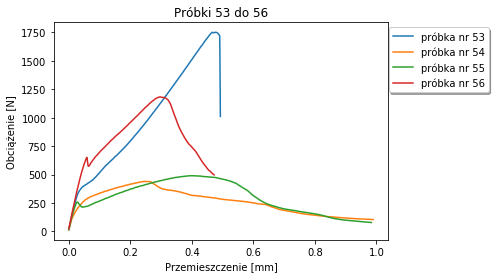

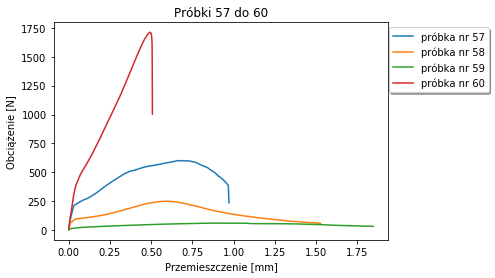

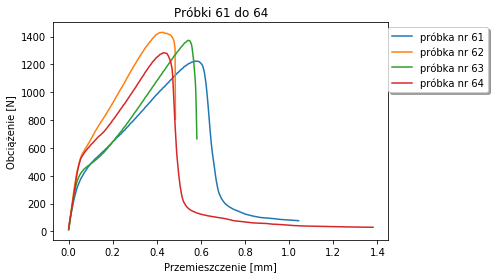

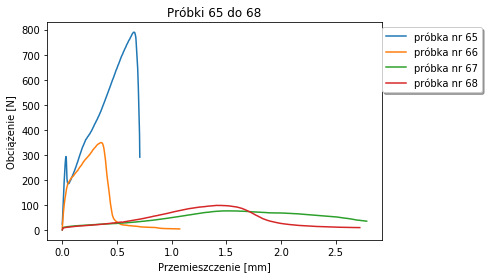

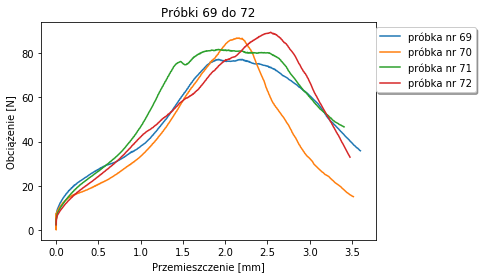

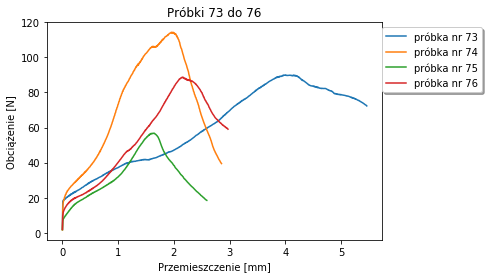

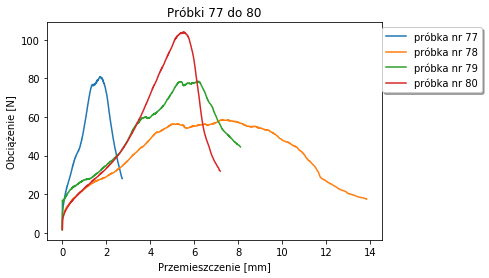

In [157]:
import math

#--- draw plots
for fig in range(math.ceil(N_sample/4)-1):
    plt.plot(strch_all[4*fig],  force_all[4*fig]  , strch_all[4*fig+1],force_all[4*fig+1],
             strch_all[4*fig+2],force_all[4*fig+2], strch_all[4*fig+3],force_all[4*fig+3])
    plt.xlabel('Przemieszczenie [mm]')
    plt.ylabel('Obciążenie [N]')
    plt.title(f'Próbki {str(4*fig+1)} do {str(4*fig+4)}')
    plt.legend([f'próbka nr {str(4*fig+x)}' for x in range(1,5)], loc='upper center', bbox_to_anchor=(1.15, 1),
              fancybox=True, shadow=True)
    plt.show()

## (2) Data analysis
### (2.1) Young coefficient analysis

Analyzing measurement number: 15
Analyzing initial measurements...
Removing 5 initial measurements due to measurement instability.
Creating linear regression model...
Linear part of data consist of 170 measurements.


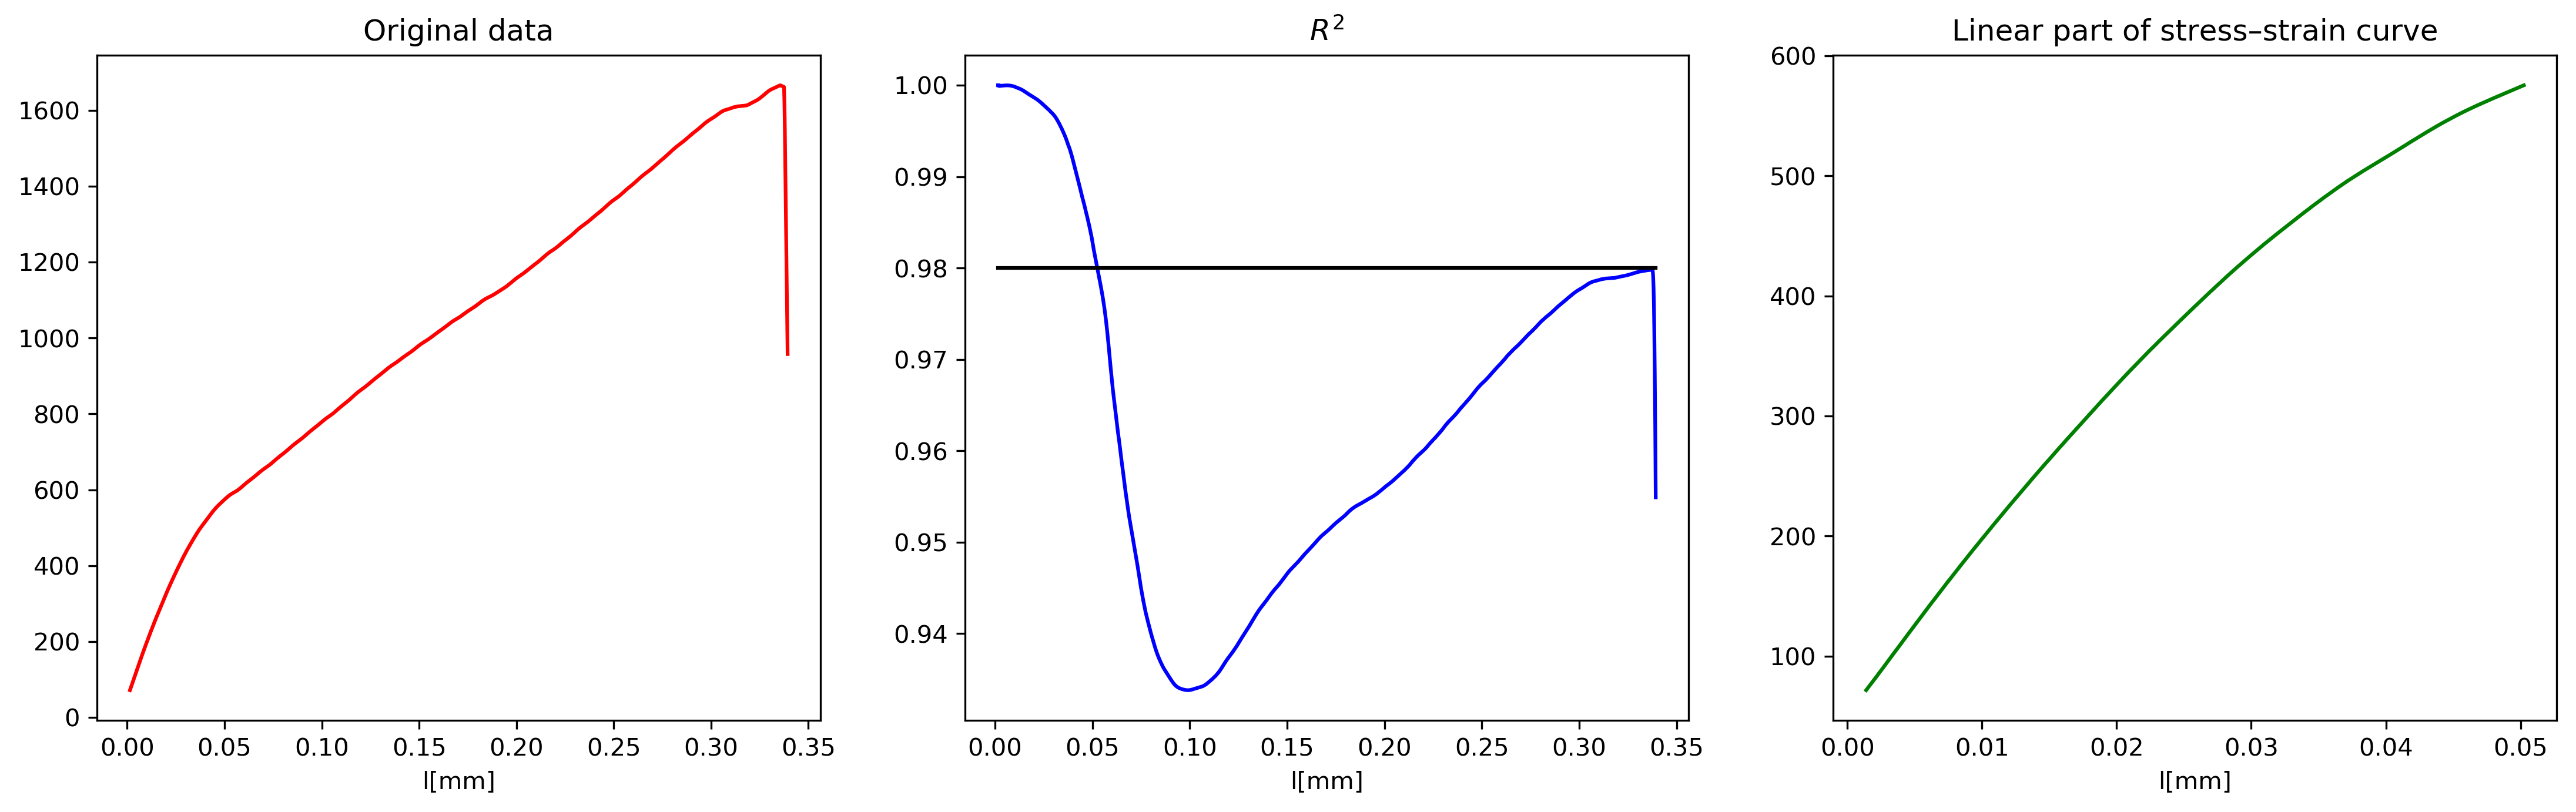

In [229]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

m = 15
threshold = .98 # r-square threshld

#---------------
x = strch_all[m-1]
y = force_all[m-1]
print(f'Analyzing measurement number: {m}')

#--- prune biased initial measures
print('Analyzing initial measurements...')
der = [ (y[idx+1]-y[idx])/(x[idx+1]-x[idx]) for idx in range(len(x)-1) ] # difference quotient
der2 = [ der[idx+1]-der[idx] for idx in range(len(der)-1) ]
idx_prune = [ idx for idx, d in enumerate(der2) if d<200 ]
idx_prune = idx_prune[0]
x = x[idx_prune:]
y = y[idx_prune:]
print(f'Removing {idx_prune} initial measurements due to measurement instability.')

#--- linear regression
print('Creating linear regression model...')
x_m = np.vstack([np.ones([len(x)]),np.asarray(x)]).T
y_m = np.asarray(y)
regr = linear_model.LinearRegression()
fit = []
for i in range(len(x)-1):
    regr.fit(x_m[:i+1], y_m[:i+1])
    fit.append(regr.score(x_m[:i+1], y_m[:i+1]))

#--- separate linear range
straight = [ idx for idx, f in enumerate(fit) if f>threshold ]
idx = 0
indices = []
while (straight[idx+1]-straight[idx]==1) and idx<len(straight)-2:
    indices.append(straight[idx])
    idx += 1
print(f'Linear part of data consist of {len(indices)} measurements.')
    
#--- generate clean data
x_clean = [x[idx] for idx in indices]
y_clean = [y[idx] for idx in indices]

#--- plotting
fig = plt.figure(figsize=(18, 5), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
plt.title('Original data')
plt.xlabel('l[mm]')
plt.plot(x, y, 'r')

plt.subplot(1,3,2)
plt.title('$R^2$')
plt.xlabel('l[mm]')
plt.plot(x[1:],fit,'b',x[1:],[threshold for i in x[1:]],'k')

plt.subplot(1,3,3)
plt.title('Linear part of stress–strain curve')
plt.xlabel('l[mm]')
plt.plot(x_clean,y_clean,'g')

### (2.2) Neat plots for print

In [2]:
samples['MetAl'] = [6,9,10,11,12,13,16,18,20,21]
samples['Env'] = [22,24,25,26,27,29,30,31,35,36]
samples['Cyjanoakryl'] = [39,40,41,43,44,46,47,48,51,39]
samples['Enopoxy'] = [52,53,55,56,60,61,62,63,64,65]
samples['Kontaktowy'] = [67,68,69,70,71,72,73,76,77,79]
plt.ioff()

for glue in samples:
    
    #--- fig 1-5
    fig = plt.figure(figsize=(5,5), dpi=300, facecolor='w', edgecolor='k')
    for i in range(5):
        plt.plot(strch_all[samples[glue][i]-1], force_all[samples[glue][i]-1], label=f'test {i+1}')
    plt.legend(framealpha=1)
    plt.xlabel('Przemieszczenie [mm]')
    plt.ylabel('Naprężenie rozciągające [N]')
    plt.grid(True)
    plt.savefig(f'{glue}_1.jpg', bbox_inches='tight')
    plt.close(fig)
    
    #--- fig 6-10
    fig = plt.figure(figsize=(5,5), dpi=300, facecolor='w', edgecolor='k')
    for i in range(5,10):
        plt.plot(strch_all[samples[glue][i]], force_all[samples[glue][i]], label=f'test {i+1}')
    plt.legend(framealpha=1)
    plt.xlabel('Przemieszczenie [mm]')
    plt.ylabel('Naprężenie rozciągające [N]')
    plt.grid(True)
    plt.savefig(f'{glue}_2.jpg', bbox_inches='tight')
    plt.close(fig)

NameError: name 'samples' is not defined

### (2.3) Neat plots [MPa] in pandas

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

path = 'cisnienie2/'

samples = dict()
samples['MetAl'] = [6,9,10,11,12,13,16,18,20,21]
samples['Env'] = [22,24,25,26,27,29,30,31,35,36]
samples['Cyjanoakryl'] = [39,40,41,43,44,46,47,48,51,39]
samples['Enopoxy'] = [52,53,55,56,60,61,62,63,64,65]
samples['Kontaktowy'] = [67,68,69,70,71,72,73,76,77,79]

for glue in samples:
    
    #--- fig 1-5
    fig = plt.figure(figsize=(5,5), dpi=300, facecolor='w', edgecolor='k')
    for i in range(5):
        #--- filename
        datafile = path+f"SpecimenClean_RawData_{str(samples[glue][i])}.csv"
        #--- process csv
        df = pd.read_csv(datafile, delimiter=';', header=None)
        df2 = df[[4,5,1]]
        df2 = df2.apply(lambda x: x.str.replace(',','.'))
        df2 = df2.apply(lambda x: x.str.replace('%',''))
        #--- fix #ARGS (missing valies)
        df2 = df2[pd.to_numeric(df2[1], errors='coerce').notnull()]
        df2 = df2[pd.to_numeric(df2[5], errors='coerce').notnull()]
        #--- create plotting variables
        x = list(pd.to_numeric(df2[4]))
        y = list(pd.to_numeric(df2[5]))   
        #--- plot
        plt.plot(x, y, label=f'test {i+1}')
    plt.legend(framealpha=1)
    plt.xlabel('Wydłużenie [%]')
    plt.ylabel('Naprężenie rozciągające [MPa]')
    plt.grid(True)
    plt.savefig(f'MPa_wyd_{glue}_1_orig.jpg', bbox_inches='tight')
    plt.close(fig)
    
    #--- fig 6-10
    fig = plt.figure(figsize=(5,5), dpi=300, facecolor='w', edgecolor='k')
    for i in range(5,10):
        #--- filename
        datafile = path+f"SpecimenClean_RawData_{str(samples[glue][i])}.csv"
        #--- process csv
        df = pd.read_csv(datafile, delimiter=';', header=None)
        df2 = df[[4,5,1]]
        df2 = df2.apply(lambda x: x.str.replace(',','.'))
        df2 = df2.apply(lambda x: x.str.replace('%',''))
        #--- fix #ARGS (missing valies)
        df2 = df2[pd.to_numeric(df2[1], errors='coerce').notnull()]
        df2 = df2[pd.to_numeric(df2[5], errors='coerce').notnull()]
        #--- create plotting variables
        x = list(pd.to_numeric(df2[4]))
        y = list(pd.to_numeric(df2[5]))   
        #--- plot
        plt.plot(x, y, label=f'test {i+1}')
    plt.legend(framealpha=1)
    plt.xlabel('Wydłużenie [%]')
    plt.ylabel('Naprężenie rozciągające [MPa]')
    plt.grid(True)
    plt.savefig(f'MPa_wyd_{glue}_2_orig.jpg', bbox_inches='tight')
    plt.close(fig)